In [ ]:
# Disclaimer: This project was made in large using knowledge from Francois Chollets Deep Learning with python, 
# and mostly code from Nicholas Renotte youtube video guide, and was modified for personal use

# 1. Setup and Data

## 1.1 Setup and dependencies

In [7]:
# should have these installed, remeber to make spereate environment using commands:
# Python3 -m venv <name> creates a v env
# python install jupyterlab
# Python -m  ipykernel install --name=<name> **puts in jupyter lab
# pip install all dependenices

## 1.2 Collect images

In [1]:
import os
import time
import uuid # for unique ids
import cv2

In [9]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [10]:
cap = cv2.VideoCapture(0) # might need to switch number, keep testing until you get right number
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() # ret is if its successful, frame is the frame
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>

In [ ]:
# Testing imshow, need extra waitkey(1) at end for some reason
img = cv2.imread('happy.jpeg')
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

## 1.3 Annotate with Labelme

In [1]:
!labelme

zsh:1: command not found: labelme


# 2. Review Dataset and build image loading function

## 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

2023-08-16 10:13:29.812435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.2 Limit GPU Memory Growth

In [ ]:
# Avoid OOM erros by setting GPU memoery .....
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.vonfig.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.test.is_gpu_available()

## 2.3 Load images into TF Pipeline

In [ ]:
images = tf.data.Dataset.list_files('data/images/*jpg', shuffle=False)

In [ ]:
images.as_numpy_iterator().next()

In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x) #takes in file path
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

## 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

## 3.1 Manually Split data into Train, Test and Val

In [ ]:
90*0.7 # 63 train

In [ ]:
90*0.15 # 14 and 13 to test and val respectively

## 3.2 Move the Matching Labels

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply image augmentation on images and labels using albumentations

## 4.1 Setup albumentations Transform Pipeline (check documentation for more info)

In [ ]:
## Importing Albumentations as alb
# https://albumentations.ai/docs/
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', # here you check docs for format for the bounding box formats for the images, if yours are different then u need to change this
                                                  label_fields=['class_labels']))

## 4.2 Load a test image and annotation with opencv and json

In [ ]:
img = cv2.imread(os.path.join('data','train','images','25d112be-1c2c-11ee-ad7d-b29c4ac6a92c.jpg'))

In [ ]:
with open(os.path.join('data','train', 'labels', '25d112be-1c2c-11ee-ad7d-b29c4ac6a92c.json'), 'r') as f:
    label = json.load(f)

In [ ]:
label['shapes'][0]['points']

## 4.3 Extract Coordinates and Rescale to match image resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [ ]:
coords

In [ ]:
coords = list(np.divide(coords, [1280,720,1280,720]))


In [ ]:
coords # now its in albumentations format

## 4.4 Apply Augmentations and View Results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes'][0][2:]

In [ ]:
augmented['bboxes']

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and run augmentation piipeline

## 5.1 Run augmentation pipeline

In [ ]:
# This will make 60 augmented images per image
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [4]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [7]:
train_images.as_numpy_iterator().next()

array([[[0.46721813, 0.46721813, 0.459375  ],
        [0.4764706 , 0.47708333, 0.46893382],
        [0.49540442, 0.50324756, 0.49148285],
        ...,
        [0.2208946 , 0.21158089, 0.16893382],
        [0.22352941, 0.21176471, 0.18333334],
        [0.2226103 , 0.21084559, 0.18339461]],

       [[0.46158087, 0.46158087, 0.45373774],
        [0.47941175, 0.47941175, 0.4715686 ],
        [0.49797794, 0.49797794, 0.4901348 ],
        ...,
        [0.22310048, 0.21035539, 0.17653187],
        [0.21531862, 0.20343137, 0.17689951],
        [0.22303921, 0.2112745 , 0.1867647 ]],

       [[0.45784312, 0.45784312, 0.45      ],
        [0.4798407 , 0.4798407 , 0.47199756],
        [0.49019608, 0.49019608, 0.48235294],
        ...,
        [0.22009803, 0.20049019, 0.18480392],
        [0.22009803, 0.20049019, 0.18480392],
        [0.22120099, 0.20159313, 0.18590686]],

       ...,

       [[0.29938725, 0.29148284, 0.25490198],
        [0.29411766, 0.29411766, 0.25490198],
        [0.29803923, 0

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

## 6.2 Load labels to Tensorflow Dataset

In [9]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Combine Label and Image Samples

# 7.1 Check partition Lengths

In [12]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 840, 840, 780, 780)

In [13]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [14]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [15]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [16]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.999  , 0.     , 1.     , 0.926  ],
        [0.4512 , 0.     , 1.     , 0.621  ],
        [0.3416 , 0.1055 , 1.     , 0.9834 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.02556, 0.2045 , 0.5107 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

## 7.3 View Images and Annotations

In [58]:
data_samples = train.as_numpy_iterator()

In [59]:
res = data_samples.next()
print(res[1])


(array([[0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8), array([[0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.2505 , 1.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.2078 , 0.524  , 1.     ],
       [0.3696 , 0.0752 , 1.     , 1.     ],
       [0.03778, 0.1812 , 0.4304 , 0.7183 ],
       [0.755  , 0.     , 1.     , 0.8916 ],
       [0.4468 , 0.04703, 1.     , 1.     ]], dtype=float16))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


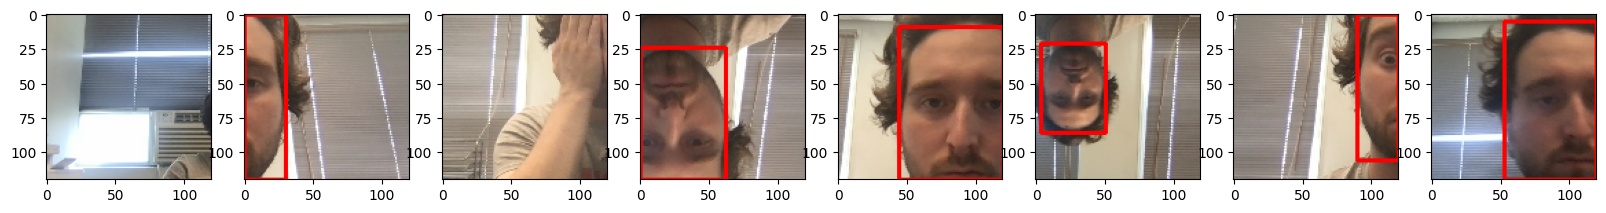

In [60]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx in range(8): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep learning using Functional API

## 8.1 Import layers amd base network

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [62]:
vgg = VGG16(include_top=False)

In [63]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build instance of Network

In [64]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## 8.4 Test out neural network

In [65]:
facetracker = build_model()

In [66]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_7[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_4 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [89]:
X, y = train.as_numpy_iterator().next()

In [90]:
X.shape

(8, 120, 120, 3)

In [91]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 341ms/step


In [92]:
classes, coords

(array([[0.42291394],
        [0.3858134 ],
        [0.32982326],
        [0.41934365],
        [0.4615524 ],
        [0.43155983],
        [0.38633382],
        [0.39773506]], dtype=float32),
 array([[0.4112243 , 0.3952761 , 0.5050635 , 0.3580816 ],
        [0.37921864, 0.47283396, 0.43468538, 0.2896434 ],
        [0.41891295, 0.42182207, 0.55964315, 0.28343445],
        [0.45035538, 0.5034507 , 0.5255286 , 0.33850327],
        [0.43672413, 0.45261335, 0.43689737, 0.27409542],
        [0.44148535, 0.43124476, 0.43512323, 0.33640286],
        [0.48970538, 0.38816395, 0.519937  , 0.45601693],
        [0.45225278, 0.41082728, 0.41566154, 0.29005376]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define optimizer and LR

In [93]:
len(train)

465

In [94]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
lr_decay

0.0007168458781362006

In [95]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss

In [96]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [97]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out loss metrics

In [98]:
localization_loss(y[1], coords).numpy()

6.698266

In [99]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.79376423>

In [100]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.698266>

# 10. Train neural network

## 10.1 Create Custom Model Class

In [101]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)    
            total_loss = batch_localizationloss+0.5*batch_classloss     
            grad = tape.gradient(total_loss, self.model.trainable_variables) 
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        classes, coords = self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [102]:
model = FaceTracker(facetracker)

In [103]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [104]:
logdir='logs'

In [105]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [106]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
465/465 [==============================] - 597s 1s/step - total_loss: 0.9053 - class_loss: 0.2246 - regress_loss: 0.7930 - val_total_loss: 0.0681 - val_class_loss: 0.0197 - val_regress_loss: 0.0582
Epoch 2/10
465/465 [==============================] - 587s 1s/step - total_loss: 0.3745 - class_loss: 0.1056 - regress_loss: 0.3217 - val_total_loss: 0.0242 - val_class_loss: 0.0069 - val_regress_loss: 0.0208
Epoch 3/10
465/465 [==============================] - 566s 1s/step - total_loss: 0.2382 - class_loss: 0.0657 - regress_loss: 0.2054 - val_total_loss: 0.0326 - val_class_loss: 0.0204 - val_regress_loss: 0.0224
Epoch 4/10
465/465 [==============================] - 555s 1s/step - total_loss: 0.1608 - class_loss: 0.0466 - regress_loss: 0.1375 - val_total_loss: 0.0607 - val_class_loss: 0.0066 - val_regress_loss: 0.0574
Epoch 5/10
465/465 [==============================] - 491s 1s/step - total_loss: 0.1149 - class_loss: 0.0301 - regress_loss: 0.0999 - val_total_loss: 0.1335 - val_c

## 10.3 Plot Performance

In [107]:
hist.history

{'total_loss': [0.9147605895996094,
  0.3677098751068115,
  1.6871511936187744,
  0.15415477752685547,
  0.1807250827550888,
  0.017186418175697327,
  0.03508104383945465,
  0.008840970695018768,
  0.012057873420417309,
  0.014630291610956192],
 'class_loss': [0.2214256227016449,
  0.10553574562072754,
  0.3412972688674927,
  0.032298386096954346,
  0.05634447559714317,
  0.003989235032349825,
  0.0017317339079454541,
  0.00035495817428454757,
  0.0001378713350277394,
  0.00030454242369160056],
 'regress_loss': [0.8040477633476257,
  0.31494200229644775,
  1.5165024995803833,
  0.1380055844783783,
  0.15255284309387207,
  0.015191800892353058,
  0.03421517834067345,
  0.00866349134594202,
  0.011988937854766846,
  0.014478020370006561],
 'val_total_loss': [0.06806596368551254,
  0.024217946454882622,
  0.03255575895309448,
  0.06068330630660057,
  0.13354501128196716,
  0.014354992657899857,
  0.01626455783843994,
  0.151089608669281,
  0.031275998800992966,
  0.006880924571305513],
 '

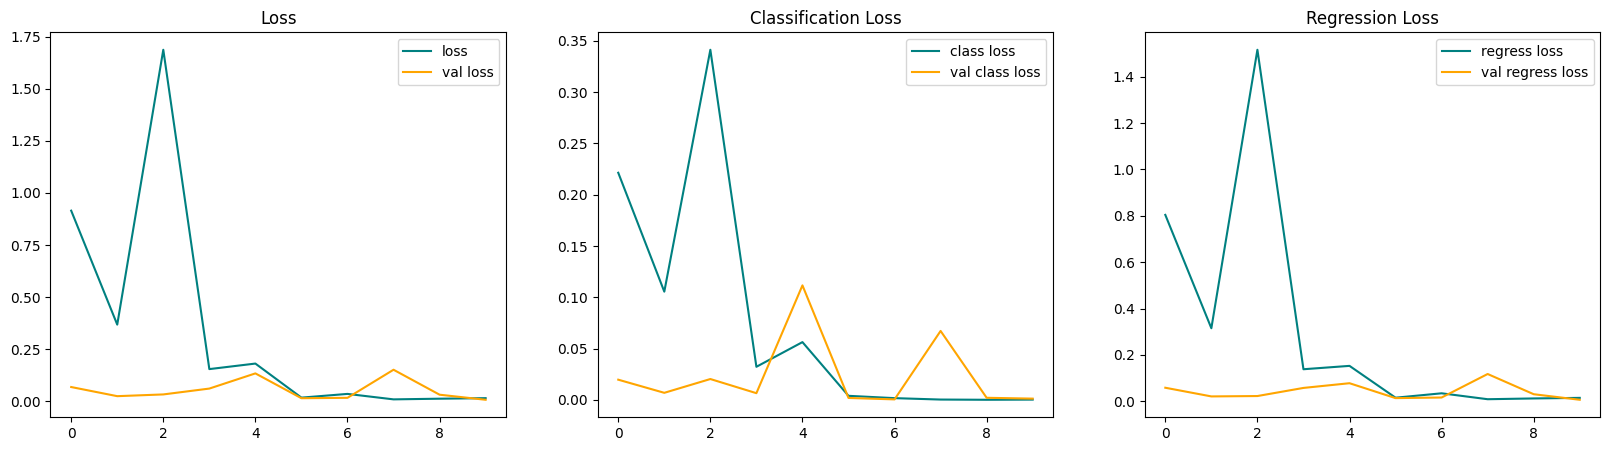

In [108]:

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make prediciton

## 11.1 Make predictions on test set

In [109]:
test_data = test.as_numpy_iterator()

In [110]:
test_sample = test_data.next()

In [111]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 236ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


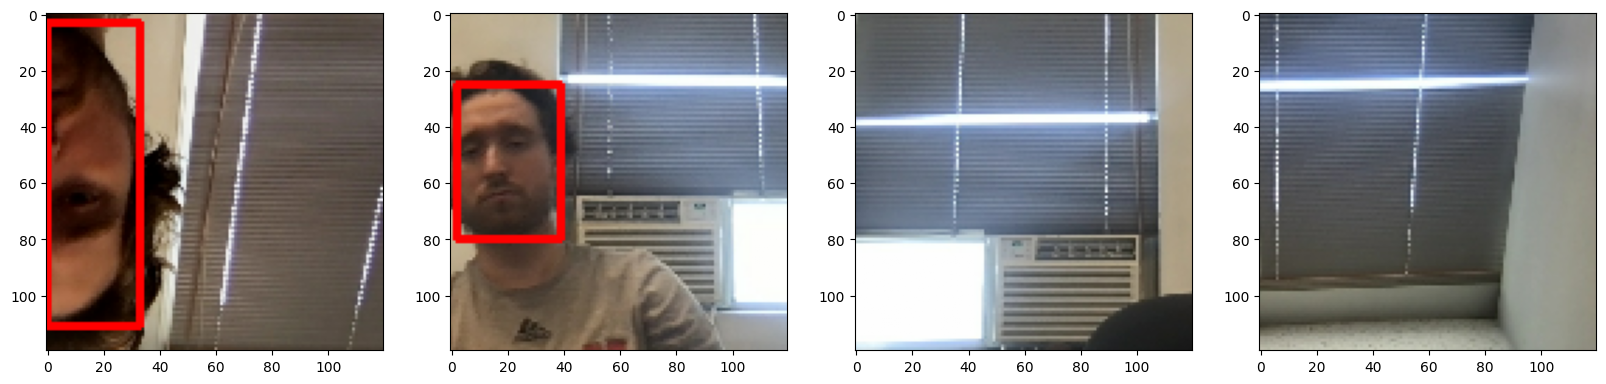

In [112]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the model

In [113]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

/Users/home/Desktop/Code/PythonProjects/FaceDetection/facedet/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 11.3 Realtime Face Detection

In [114]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('Facetrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 45ms/step
